![]('/content/characters_illustration.png')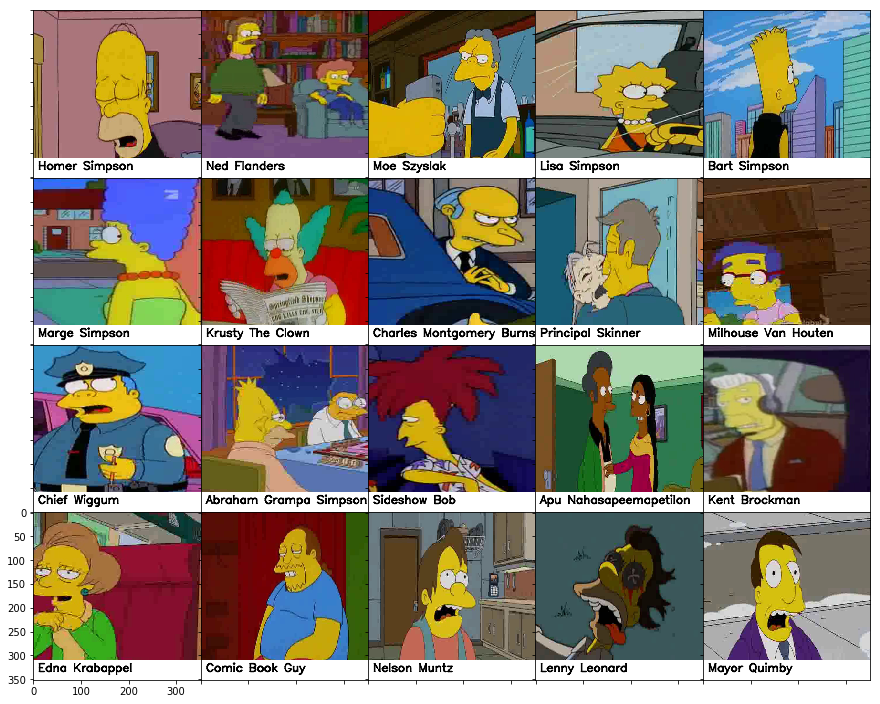

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torch import nn, optim, functional as F
from torchvision import datasets, models, transforms as tfs
import torchvision

from matplotlib import rcParams

from tqdm.notebook import tqdm, trange

from IPython.display import clear_output

import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip '/content/gdrive/MyDrive/journey-springfield.zip'
clear_output()

In [3]:
rcParams['figure.figsize'] = (15, 8)

In [35]:
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
BATCH_SIZE = 16

train_tfs = tfs.Compose((
    tfs.Resize((256, 256)),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize(mean, std)
))

data = datasets.ImageFolder('/content/train/simpsons_dataset', train_tfs)
train_ind, val_ind = train_test_split(list(range(len(data))), test_size=0.15)
dataset = {'train': Subset(data, train_ind),
           'test': Subset(data, val_ind)}

loaders = {x: DataLoader(dataset[x], batch_size=BATCH_SIZE, num_workers=2) for x in ['train', 'test']}

name_classes = np.array(data.classes)
datasets_sizes = {x: len(dataset[x]) for x in ['train', 'test']}

for i in range(len(name_classes)):
  print(i+1, name_classes[i])
print('\n',datasets_sizes)

1 abraham_grampa_simpson
2 agnes_skinner
3 apu_nahasapeemapetilon
4 barney_gumble
5 bart_simpson
6 carl_carlson
7 charles_montgomery_burns
8 chief_wiggum
9 cletus_spuckler
10 comic_book_guy
11 disco_stu
12 edna_krabappel
13 fat_tony
14 gil
15 groundskeeper_willie
16 homer_simpson
17 kent_brockman
18 krusty_the_clown
19 lenny_leonard
20 lionel_hutz
21 lisa_simpson
22 maggie_simpson
23 marge_simpson
24 martin_prince
25 mayor_quimby
26 milhouse_van_houten
27 miss_hoover
28 moe_szyslak
29 ned_flanders
30 nelson_muntz
31 otto_mann
32 patty_bouvier
33 principal_skinner
34 professor_john_frink
35 rainier_wolfcastle
36 ralph_wiggum
37 selma_bouvier
38 sideshow_bob
39 sideshow_mel
40 snake_jailbird
41 troy_mcclure
42 waylon_smithers

 {'train': 17793, 'test': 3140}


In [5]:
def imshow(imgs: torch.Tensor, lables=None):
  imgs = imgs.detach().cpu().numpy().transpose((1, 2, 0))
  imgs = imgs * std + mean
  imgs = np.clip(imgs, 0, 1)

  plt.figure(figsize=(20, 14))
  
  if not lables is None:
    plt.title(lables)
  
  plt.axis('off')
  plt.imshow(imgs)
  plt.show()

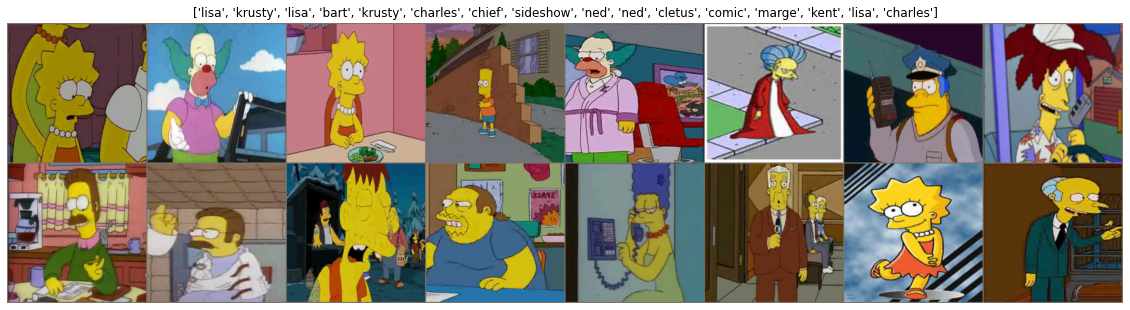

In [6]:
inputs, classes = next(iter(loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, [name_classes[i].split('_')[0] for i in classes])

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device == 'cuda'

True

In [8]:
def show_history(acc, loss):
  plt.plot(acc['train'], 'b', label='Train accuracy')
  plt.plot(acc['test'], 'r', label='Test accuracy')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

  plt.plot(loss['train'], 'b', label='Train loss')
  plt.plot(loss['test'], 'r', label='Test loss')
  plt.legend()
  plt.title('Loss')
  plt.show()

In [9]:
def train_model(model, loss_fn, optim, scheduler, epochs=50):
  history_loss = {'train': [], 'test': []}
  history_acc = {'train': [], 'test': []}
  best_acc = 0
  best_params = model.state_dict()
  for epoch in trange(epochs):
    running_loss = {'train': 0, 'test': 0}
    running_acc = {'train': 0, 'test': 0}
    for mode in (['train', 'test']):
      for i, batch in enumerate(tqdm(loaders[mode])):
        X, y_real = batch
        if torch.cuda.is_available():
          X, y_real = X.cuda(), y_real.cuda()
        
        if mode == 'train':
          model.train()
          optim.zero_grad()

          y_pred = model(X)

          loss = loss_fn(y_pred, y_real)
          loss.backward()
          optim.step()

        else:
          model.eval()
          with torch.no_grad():
            y_pred = model(X)
            loss = loss_fn(y_pred, y_real)
        
        running_loss[mode] += loss.item()
        running_acc[mode] += torch.sum(torch.argmax(y_pred, -1) == y_real) / datasets_sizes[mode]
        
        if i % (datasets_sizes[mode] / BATCH_SIZE // 3) == 0 and i != 0:
          print(f'Epoch:  {epoch}     Iter:  {i}    Loss:  {running_loss[mode]}')
          history_loss[mode].append(running_loss[mode])
          running_loss[mode] = 0
          
        del loss
        torch.cuda.empty_cache()

      if mode == 'test':
        print('Accuracy:  ', running_acc[mode].item())

      if mode == 'test' and best_acc < running_acc[mode]:
        best_acc = running_acc[mode]
        best_params = model.state_dict()

      history_acc[mode].append(running_acc[mode].cpu().numpy())

    scheduler.step()
  model.load_state_dict(best_params)
  return model, history_acc, history_loss

<h1>Models</h1>

# ResNet

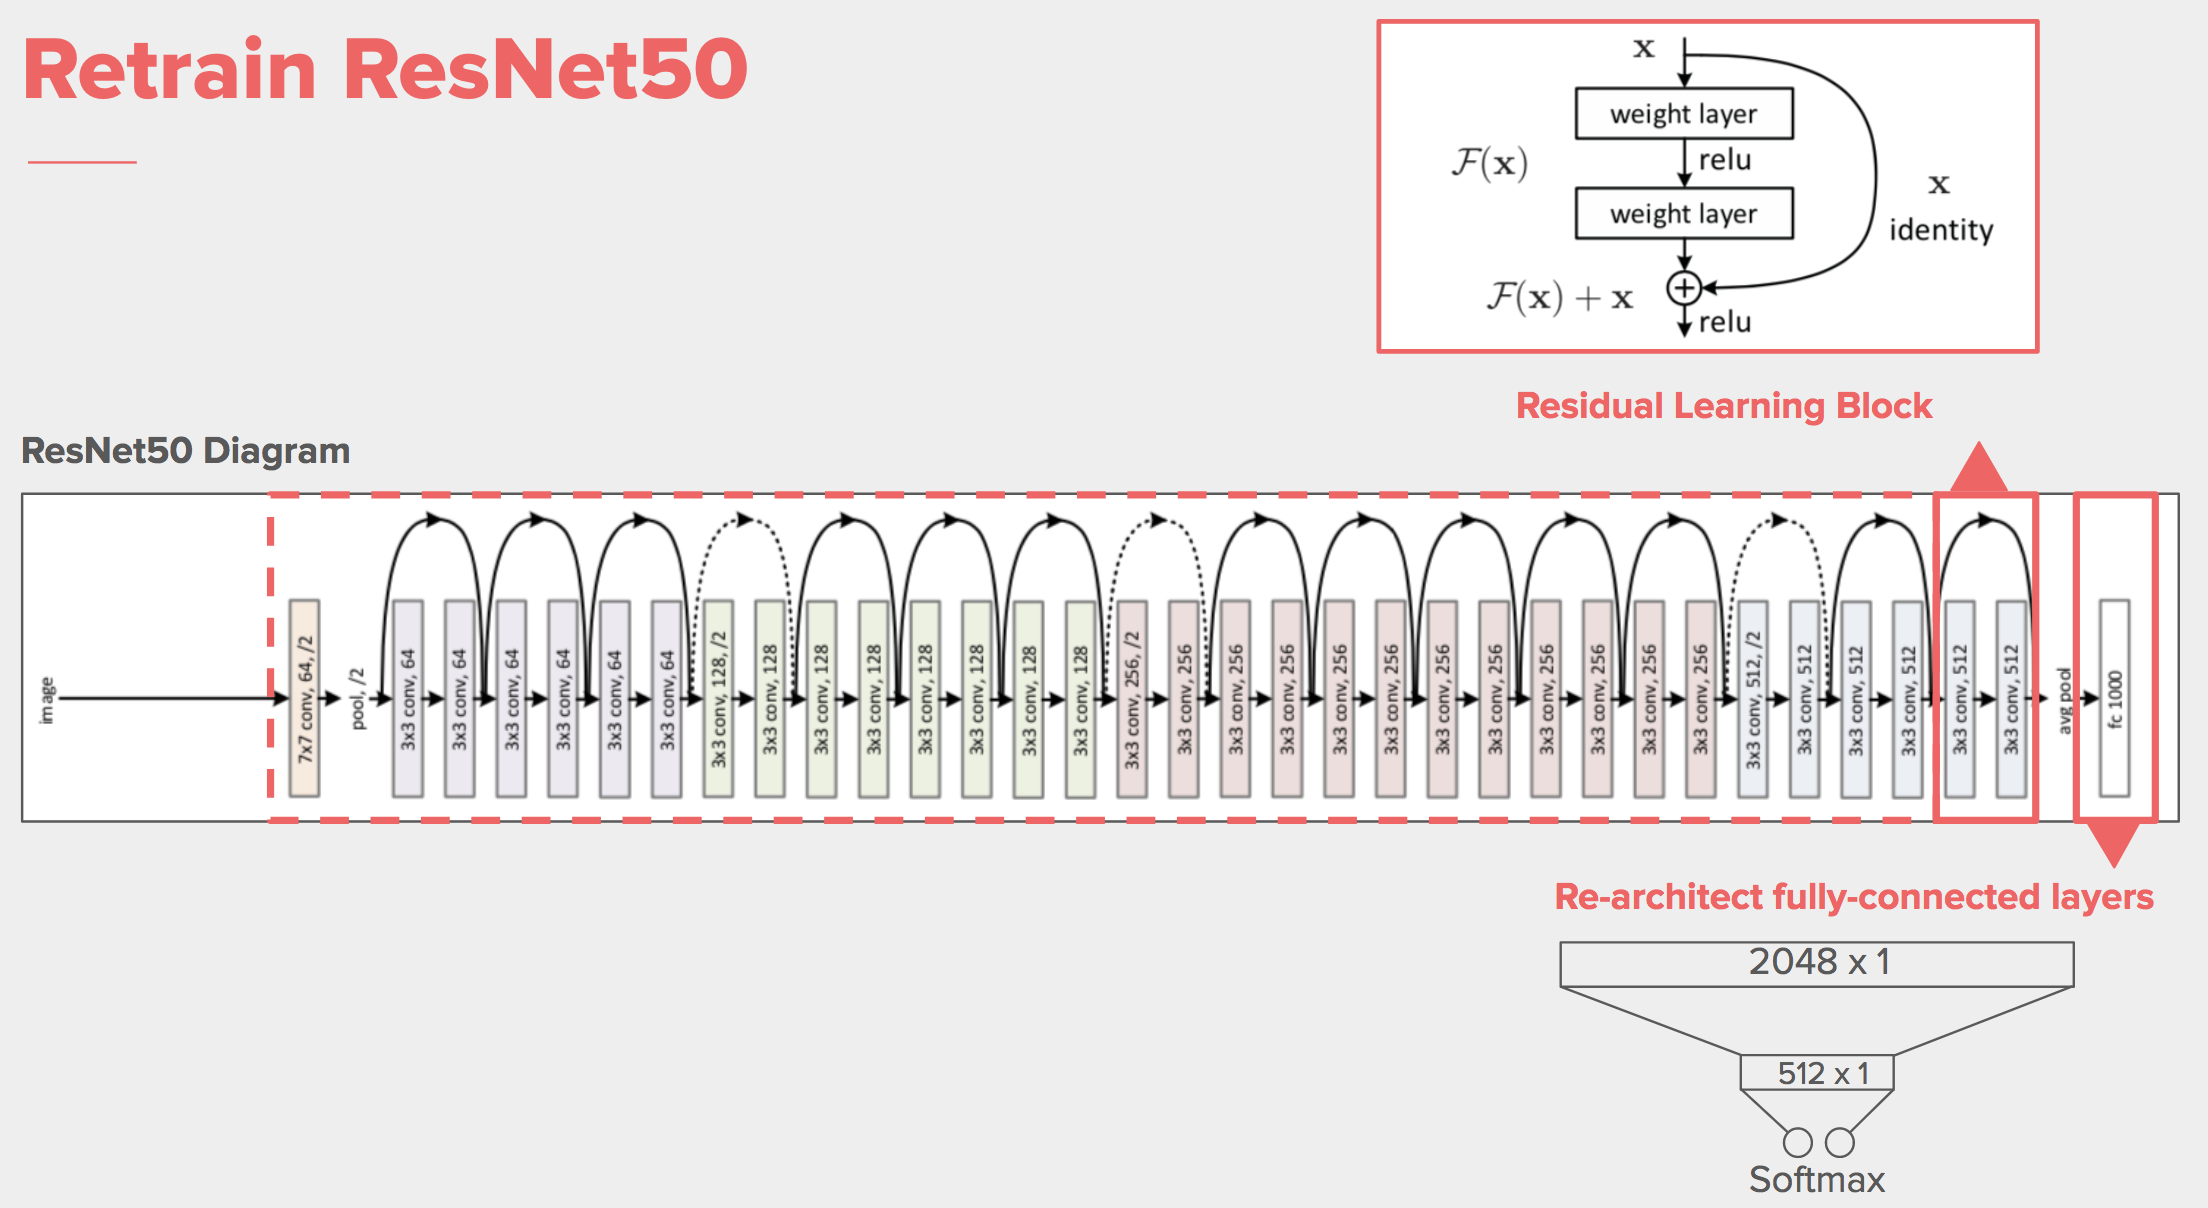

In [10]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels,
                               out_channels * self.expansion,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)

        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x += identity
        x = self.relu(x)

        return x

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels,
                          out_channels * 4,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(out_channels * 4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

In [12]:
def ResNet50(img_channels=3, num_classes=len(name_classes)):
  return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

In [13]:
def ResNet101(img_channels=3, num_classes=len(name_classes)):
  return ResNet(block, [3, 4, 28, 3], img_channels, num_classes)

In [14]:
def ResNet152(img_channels=3, num_classes=len(name_classes)):
  return ResNet(block, [3, 8, 36, 3], img_channels, num_classes)

In [16]:
resnet = ResNet101()

if torch.cuda.is_available():
  resnet.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5)

resnet, history_acc_resnet, history_loss_resnet = train_model(resnet, loss_fn, optimizer, lr_scheduler, 12)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  1097.4868431091309
Epoch:  740    Loss:  776.721221446991
Epoch:  1110    Loss:  584.4838026165962


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  128.7388560771942
Epoch:  130    Loss:  117.88386178016663
Epoch:  195    Loss:  133.11134707927704
Accuracy:   0.5398089289665222


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  468.5613263249397
Epoch:  740    Loss:  393.9369819164276
Epoch:  1110    Loss:  348.396357730031


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  61.660358399152756
Epoch:  130    Loss:  55.9560721218586
Epoch:  195    Loss:  64.78093972802162
Accuracy:   0.749682605266571


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  308.2818551659584
Epoch:  740    Loss:  271.34408236294985
Epoch:  1110    Loss:  254.82141271978617


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  45.61955635249615
Epoch:  130    Loss:  47.94284602999687
Epoch:  195    Loss:  54.28611297160387
Accuracy:   0.8012748956680298


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  228.9440066330135
Epoch:  740    Loss:  209.14620681107044
Epoch:  1110    Loss:  194.6233190521598


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  45.336155246943235
Epoch:  130    Loss:  40.427232667803764
Epoch:  195    Loss:  46.3003295250237
Accuracy:   0.8232494592666626


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  186.1390251107514
Epoch:  740    Loss:  176.87245198711753
Epoch:  1110    Loss:  161.2393177561462


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  42.74608851969242
Epoch:  130    Loss:  38.992356993258
Epoch:  195    Loss:  45.88668520748615
Accuracy:   0.8363069295883179


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  117.57809079205617
Epoch:  740    Loss:  85.5925692259334
Epoch:  1110    Loss:  60.45157265942544


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  21.28433264279738
Epoch:  130    Loss:  19.26229087356478
Epoch:  195    Loss:  23.828846553340554
Accuracy:   0.9181536436080933


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  73.94858924066648
Epoch:  740    Loss:  61.44968994357623
Epoch:  1110    Loss:  47.58127531269565


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  19.27061276533641
Epoch:  130    Loss:  18.196681512286887
Epoch:  195    Loss:  22.095817399211228
Accuracy:   0.9264338612556458


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  59.22786193387583
Epoch:  740    Loss:  46.77848597965203
Epoch:  1110    Loss:  35.50947237224318


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  19.460523690562695
Epoch:  130    Loss:  18.818667304702103
Epoch:  195    Loss:  20.472442742437124
Accuracy:   0.9302554726600647


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  44.55317595577799
Epoch:  740    Loss:  33.80142623663414
Epoch:  1110    Loss:  24.94906716560945


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  19.84144108684268
Epoch:  130    Loss:  16.880588099884335
Epoch:  195    Loss:  20.34632405382581
Accuracy:   0.9315293431282043


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  31.842001208802685
Epoch:  740    Loss:  22.994835922145285
Epoch:  1110    Loss:  17.558023005723953


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  19.871684766723774
Epoch:  130    Loss:  18.211733078118414
Epoch:  195    Loss:  20.578040244756266
Accuracy:   0.9312108755111694


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  19.84601587295765
Epoch:  740    Loss:  14.258519386756234
Epoch:  1110    Loss:  9.611014050839003


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  18.386897310847417
Epoch:  130    Loss:  17.494729377154727
Epoch:  195    Loss:  20.37658256466966
Accuracy:   0.9350324869155884


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  15.9720170890796
Epoch:  740    Loss:  11.012019049900118
Epoch:  1110    Loss:  9.307911092299037


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  19.68441022548359
Epoch:  130    Loss:  17.988582631514873
Epoch:  195    Loss:  21.20818142371718
Accuracy:   0.9312108755111694


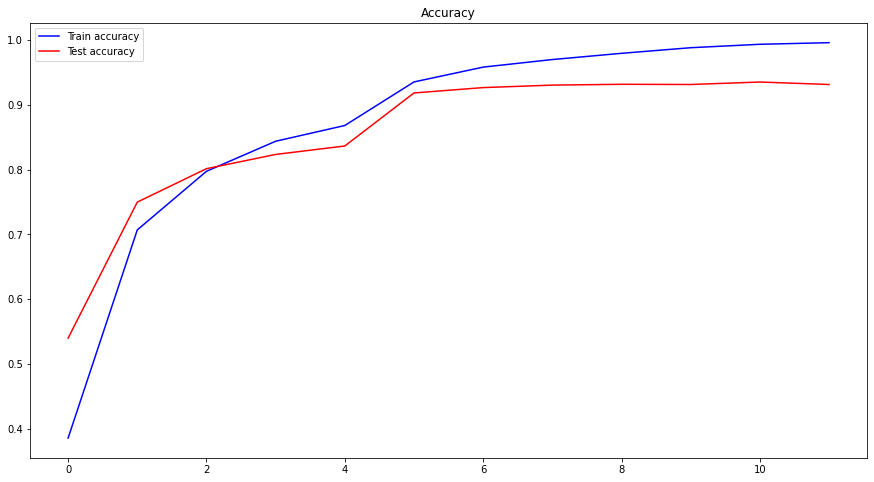

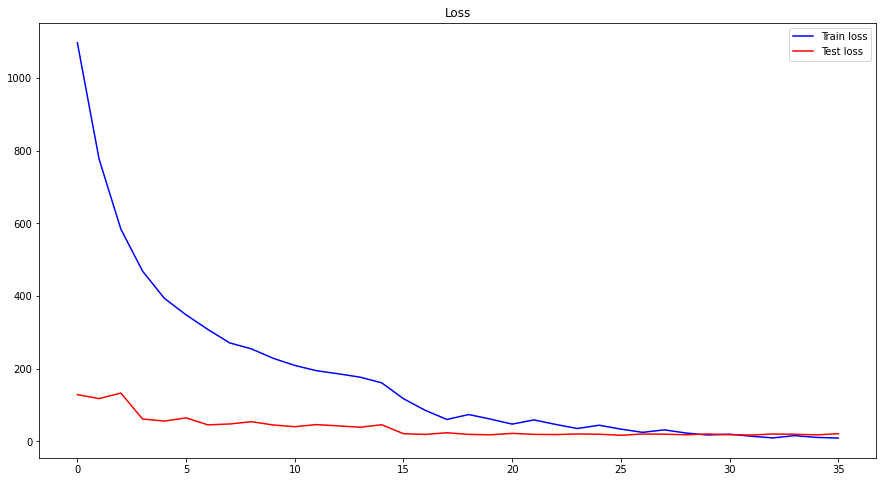

In [17]:
show_history(history_acc_resnet, history_loss_resnet)

# VGG 16

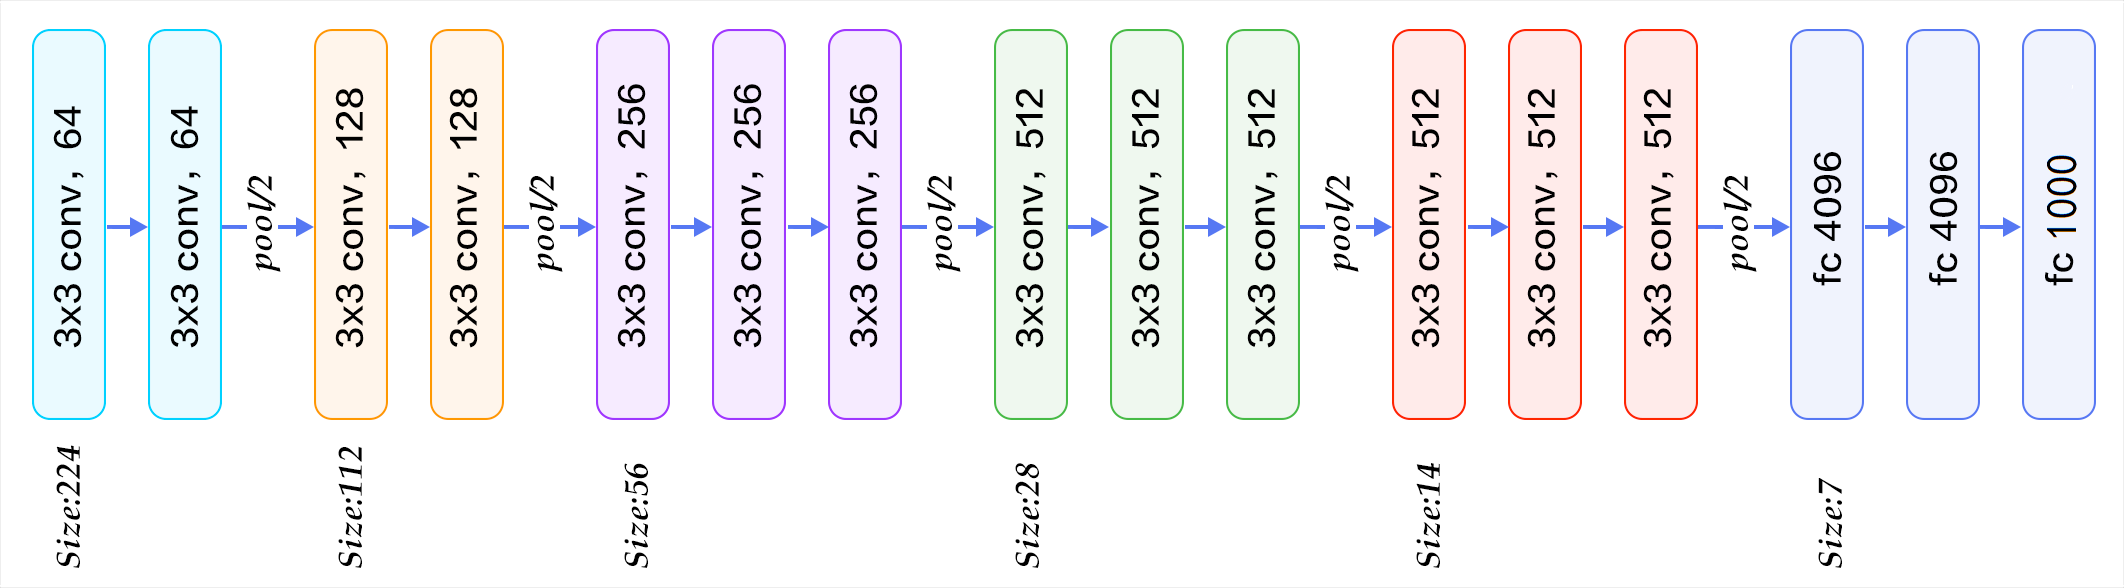

In [18]:
VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
class VGG16_net(nn.Module):
    def __init__(self, in_channels=3, num_classes=len(name_classes)):
      super(VGG16_net, self).__init__()
      self.in_channels = in_channels
      self.num_classes = num_classes
      self.conv_layers = self.make_conv_layer(VGG16)

      self.fcs = nn.Sequential(
          nn.Linear(512 * 8 * 8, 4096),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(4096, num_classes)
      )

    def forward(self, x):
      x = self.conv_layers(x)
      x = x.reshape(x.shape[0], -1)
      x = self.fcs(x)

      return x

    def make_conv_layer(self, architecture):
      layers = []
      in_channels = self.in_channels
      
      for x in architecture:
        if type(x) == int:
          out_channels = x
          
          layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                               kernel_size=3, stride=1, padding=1),
                     nn.BatchNorm2d(x),
                     nn.ReLU()]
          in_channels = out_channels
        elif x == 'M':
          layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

      return nn.Sequential(*layers)

In [19]:
vgg16 = VGG16_net()

if torch.cuda.is_available():
  vgg16.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(vgg16.parameters(), lr=1e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5)

vgg16, history_acc_vgg16, history_loss_vgg16 = train_model(vgg16, loss_fn, optimizer, lr_scheduler, 12)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  1202.4809596538544
Epoch:  740    Loss:  1088.8717975616455
Epoch:  1110    Loss:  999.5282866954803


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  164.03102660179138
Epoch:  130    Loss:  165.28831601142883
Epoch:  195    Loss:  165.38804078102112
Accuracy:   0.29713380336761475


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  922.3633826971054
Epoch:  740    Loss:  852.9075458049774
Epoch:  1110    Loss:  787.5203850269318


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  123.61697959899902
Epoch:  130    Loss:  118.75679230690002
Epoch:  195    Loss:  123.08318173885345
Accuracy:   0.4777071177959442


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  711.0896006822586
Epoch:  740    Loss:  642.9444598555565
Epoch:  1110    Loss:  603.8290888667107


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  105.10358667373657
Epoch:  130    Loss:  98.777439057827
Epoch:  195    Loss:  106.02642804384232
Accuracy:   0.5608280301094055


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  568.7328269481659
Epoch:  740    Loss:  519.8662225008011
Epoch:  1110    Loss:  496.9182479381561


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  85.63023406267166
Epoch:  130    Loss:  79.41960799694061
Epoch:  195    Loss:  87.51629328727722
Accuracy:   0.6312106847763062


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  473.08756989240646
Epoch:  740    Loss:  426.60625690221786
Epoch:  1110    Loss:  418.3208798766136


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  68.22645837068558
Epoch:  130    Loss:  62.794593915343285
Epoch:  195    Loss:  70.39972332119942
Accuracy:   0.7121027708053589


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  360.80070258677006
Epoch:  740    Loss:  324.9835896641016
Epoch:  1110    Loss:  302.05945160984993


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  51.2500202357769
Epoch:  130    Loss:  47.677161149680614
Epoch:  195    Loss:  57.61497497558594
Accuracy:   0.7793005108833313


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  318.8318414017558
Epoch:  740    Loss:  296.45268455147743
Epoch:  1110    Loss:  284.0301810950041


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  48.459826588630676
Epoch:  130    Loss:  44.38363295793533
Epoch:  195    Loss:  54.67216895520687
Accuracy:   0.7875807285308838


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  298.38274005427957
Epoch:  740    Loss:  277.1855066269636
Epoch:  1110    Loss:  265.23565124720335


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  46.50042347609997
Epoch:  130    Loss:  42.09569963812828
Epoch:  195    Loss:  51.87482015788555
Accuracy:   0.7993640899658203


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  283.66012366861105
Epoch:  740    Loss:  262.74179796874523
Epoch:  1110    Loss:  254.08522388339043


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  45.0306838452816
Epoch:  130    Loss:  40.16574363410473
Epoch:  195    Loss:  49.87281955778599
Accuracy:   0.8070076107978821


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  267.4814360998571
Epoch:  740    Loss:  250.64383241534233
Epoch:  1110    Loss:  239.19574611634016


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  43.152036756277084
Epoch:  130    Loss:  38.092045836150646
Epoch:  195    Loss:  49.749273508787155
Accuracy:   0.8168801665306091


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  253.1179195344448
Epoch:  740    Loss:  235.95444749295712
Epoch:  1110    Loss:  219.9796514287591


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  42.87251344323158
Epoch:  130    Loss:  37.323359698057175
Epoch:  195    Loss:  48.6221614331007
Accuracy:   0.8235680460929871


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch:  370    Loss:  248.99955483525991
Epoch:  740    Loss:  228.48376635834575
Epoch:  1110    Loss:  220.8235483393073


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch:  65    Loss:  42.718573823571205
Epoch:  130    Loss:  37.917330116033554
Epoch:  195    Loss:  47.45798824727535
Accuracy:   0.8213387131690979


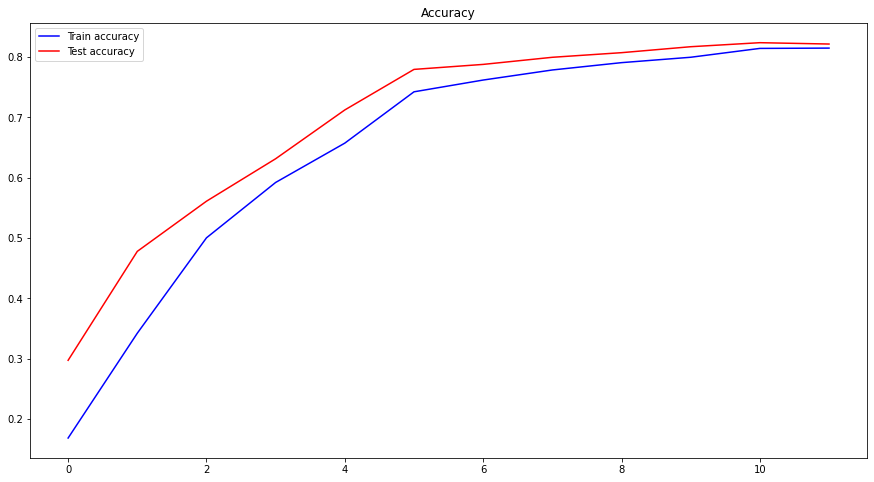

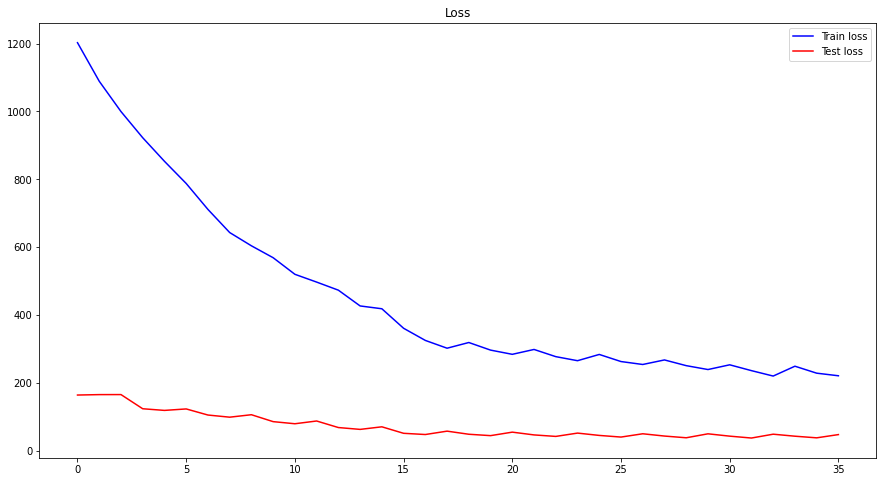

In [20]:
show_history(history_acc_vgg16, history_loss_vgg16)

# VGG19

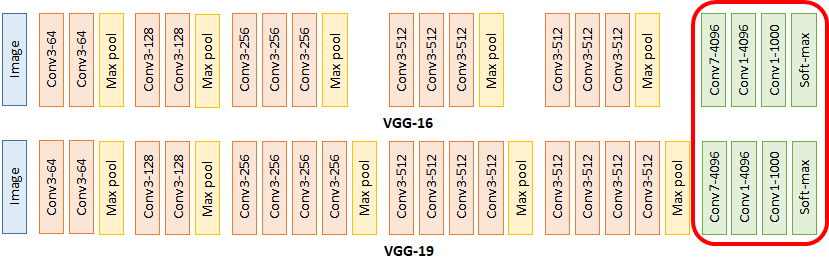

In [21]:
VGG19 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
class VGG19_net(nn.Module):
    def __init__(self, in_channels=3, num_classes=len(name_classes)):
      super(VGG19_net, self).__init__()
      self.in_channels = in_channels
      self.num_classes = num_classes
      self.conv_layers = self.make_conv_layer(VGG19)

      self.fcs = nn.Sequential(
          nn.Linear(512 * 8 * 8, 4096),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(4096, num_classes)
      )

    def forward(self, x):
      x = self.conv_layers(x)
      x = x.reshape(x.shape[0], -1)
      x = self.fcs(x)

      return x

    def make_conv_layer(self, architecture):
      layers = []
      in_channels = self.in_channels
      
      for x in architecture:
        if type(x) == int:
          out_channels = x
          
          layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                               kernel_size=3, stride=1, padding=1),
                     nn.BatchNorm2d(x),
                     nn.ReLU()]
          in_channels = out_channels
        elif x == 'M':
          layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

      return nn.Sequential(*layers)

In [ ]:
# vgg19 = VGG19_net()

# if torch.cuda.is_available():
#   vgg19.cuda()

# loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(vgg19.parameters(), lr=1e-4)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5)

# vgg19, history_acc_vgg19, history_loss_vgg19 = train_model(vgg19, loss_fn, optimizer, lr_scheduler, 12)

In [ ]:
# show_history(history_acc_vgg19, history_loss_vgg19)

#Ploting results

In [ ]:
plt.plot(history_acc_resnet, label='ResNet accuracy')
plt.plot(history_acc_vgg16, label='VGG16 accuracy')
plt.title('Models accuracy')
plt.legend()
plt.show()

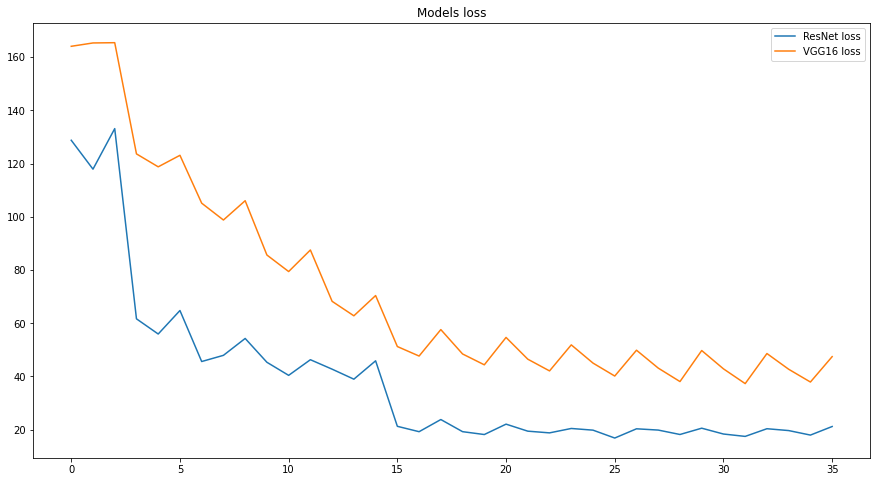

In [24]:
plt.plot(history_loss_resnet['test'], label='ResNet loss')
plt.plot(history_loss_vgg16['test'], label='VGG16 loss')
plt.title('Models loss')
plt.legend()
plt.show()

#Submission

In [25]:
train_tfs = tfs.Compose((
    tfs.Resize((256, 256)),
    tfs.ToTensor(),
    tfs.Normalize(mean, std)
))

dataset_test = datasets.ImageFolder(root='/content/testset/', transform=train_tfs)

dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=BATCH_SIZE)

test_filenames = [fn[0].split('/')[-1] for fn in dataset_test.imgs]

In [26]:
def predict(model, data):
  model.eval()
  preds = []
  with torch.no_grad():
    for X, y in data:
      if torch.cuda.is_available():
        X = X.cuda()
      preds.extend(torch.argmax(model(X), -1).detach().cpu().numpy())

  return preds

In [37]:
pred = predict(resnet, dataloader_test)
pred = name_classes[pred]

In [38]:
submission = pd.DataFrame({'id': test_filenames, 'Expected': pred}).sort_values('id')

In [40]:
submission.to_csv('./submission.csv', index=False)

In [39]:
submission[:5]

,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
